### [kdegrave.github.io](https://kdegrave.github.io/)

### Introduction

The Federal National Mortgage Association (FNMA), also known as Fannie Mae, is a government-sponsored corporation founded in 1938. In short, Fannie Mae purchases mortgage loans from primary lenders like Bank of America and Wells Fargo, among several others. After these mortgages are acquired, Fannie Mae sells them as securities in the bond market. These sales "provide lenders with the liquidity to fund more mortgages, and until 2006, the mortgage-backed securities (MBS) sold by [Fannie Mae] were considered solid investments." Unfortunately, however, not all borrowers whose loans have been purchased by Fannie Mae are able to repay their mortgages in a timely manner, and many end up defaulting at some point. In fact, between 2006 and 2008, many hundreds of thousands of people had defaulted, causing these securities to decreases significantly in value, thereby strongly impacting the global economy.

On its website, Fannie Mae has made a subset of its Single Family Loan Performance (SFLP) data available to anyone interested in looking at it. The SFLP data cover the years 2000-2015, and can be downloaded here. The goal of this project it so see if we can predict from this data, with some accuracy, those borrowers who are most at risk of defaulting on their mortgage loans. Let's get started!

### Loading and cleaning the data
Once downloaded, one will find that the SFLP data is divided into two files called Acquisition*.txt and Performance*.txt, where the * is a placeholder for the particular year and quarter of interest. For the purposes of this project, we're using the quarter 4 data of 2007 which contains a reasonable number of defaults to analyze. The aquisition data contains personal information for each of the borrowers, including an individual's debt-to-income ratio, credit score, and loan amount, among several other things. The perfomance data contains information regarding loan payment history, and whether or not a borrower ended up defaulting on their loan. Additional information regarding the contents of these two files can be found in the Layout and Glossary of Terms files.

Let’s begin by importing the appropriate Python libraries and reading in the data.

In [1]:
%config InlineBackend.figure_format = 'retina'

In [71]:
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from matplotlib.pyplot import *
import pandas as pd
import numpy as np
import warnings

warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 500)

The data dictionary contains a list of the column names along with their definitions.

In [3]:
data_dictionary = pd.read_excel('./data/loan_performance_glossary.xlsx', sheet_name='Data Dictionary')

In [4]:
data_dictionary.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107
Field Name,Reference Pool ID,Loan Identifier,Monthly Reporting Period,Channel,Seller Name,Servicer Name,Master Servicer,Original Interest Rate,Current Interest Rate,Original UPB,UPB at Issuance,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,Loan Age,Remaining Months to Legal Maturity,Remaining Months To Maturity,Maturity Date,Original Loan to Value Ratio (LTV),Original Combined Loan to Value Ratio (CLTV),Number of Borrowers,Debt-To-Income (DTI),Borrower Credit Score at Origination,Co-Borrower Credit Score at Origination,First Time Home Buyer Indicator,Loan Purpose,Property Type,Number of Units,Occupancy Status,Property State,Metropolitan Statistical Area (MSA),Zip Code Short,Mortgage Insurance Percentage,Amortization Type,Prepayment Penalty Indicator,Interest Only Loan Indicator,Interest Only First Principal And Interest Pay...,Months to Amortization,Current Loan Delinquency Status,Loan Payment History,Modification Flag,Mortgage Insurance Cancellation Indicator,Zero Balance Code,Zero Balance Effective Date,UPB at the Time of Removal,Repurchase Date,Scheduled Principal Current,Total Principal Current,Unscheduled Principal Current,Last Paid Installment Date,Foreclosure Date,Disposition Date,Foreclosure Costs,Property Preservation and Repair Costs,Asset Recovery Costs,Miscellaneous Holding Expenses and Credits,Associated Taxes for Holding Property,Net Sales Proceeds,Credit Enhancement Proceeds,Repurchase Make Whole Proceeds,Other Foreclosure Proceeds,Non-Interest Bearing UPB,Principal Forgiveness Amount,Original List Start Date,Original List Price,Current List Start Date,Current List Price,Borrower Credit Score At Issuance,Co-Borrower Credit Score At Issuance,Borrower Credit Score Current,Co-Borrower Credit Score Current,Mortgage Insurance Type,Servicing Activity Indicator,Current Period Modification Loss Amount,Cumulative Modification Loss Amount,Current Period Credit Event Net Gain or Loss,Cumulative Credit Event Net Gain or Loss,HomeReady® Program Indicator,Foreclosure Principal Write-off Amount,Relocation Mortgage Indicator,Zero Balance Code Change Date,Loan Holdback Indicator,Loan Holdback Effective Date,Delinquent Accrued Interest,Property Valuation Method,High Balance Loan Indicator,ARM Initial Fixed-Rate Period ≤ 5 YR Indicator,ARM Product Type,Initial Fixed-Rate Period,Interest Rate Adjustment Frequency,Next Interest Rate Adjustment Date,Next Payment Change Date,Index,ARM Cap Structure,Initial Interest Rate Cap Up Percent,Periodic Interest Rate Cap Up Percent,Lifetime Interest Rate Cap Up Percent,Mortgage Margin,ARM Balloon Indicator,ARM Plan Number,Borrower Assistance Plan,High Loan to Value (HLTV) Refinance Option Ind...,Deal Name,Repurchase Make Whole Proceeds Flag,Alternative Delinquency Resolution,Alternative Delinquency Resolution Count,Total Deferral Amount


There are 108 columns in the dataset and they include information regarding the loan servicer, interest rate, loan amount, origination date, etc. The data we'll be analyzing in this notebook come from loans with origination dates in the last quarter of 2007. This corresponds to a time during the housing market crisis when a large number of loans were issues which eventually went into foreclosure. I went ahead and split the data sample into default and non-default sets beforehand to make things easier. Let's read them in.

In [5]:
default = pd.read_csv('./data/default.csv')

non_default = pd.read_csv('./data/non_default.csv')

The "default" class will be given a target value of 1, while the "non-default" class will be given a target value of 0. There are 100,000 non-defaults and about 38,000 defaults. There's a large subset of columns that are completely null, so we can remove those here as well.

In [6]:
default['target'] = 1

non_default['target'] = 0

In [7]:
df = non_default.append(default).reset_index(drop=True).dropna(axis=1, how='all')

In [8]:
df['target'].value_counts()

0    100000
1     38058
Name: target, dtype: int64

In [9]:
df.head()

,Loan Identifier,Monthly Reporting Period,Channel,Seller Name,Servicer Name,Original Interest Rate,Current Interest Rate,Original UPB,Current Actual UPB,Original Loan Term,Origination Date,First Payment Date,Loan Age,Remaining Months to Legal Maturity,Remaining Months To Maturity,Maturity Date,Original Loan to Value Ratio (LTV),Original Combined Loan to Value Ratio (CLTV),Number of Borrowers,Debt-To-Income (DTI),Borrower Credit Score at Origination,Co-Borrower Credit Score at Origination,First Time Home Buyer Indicator,Loan Purpose,Property Type,Number of Units,Occupancy Status,Property State,Metropolitan Statistical Area (MSA),Zip Code Short,Mortgage Insurance Percentage,Amortization Type,Prepayment Penalty Indicator,Interest Only Loan Indicator,Current Loan Delinquency Status,Loan Payment History,Modification Flag,Zero Balance Code,Zero Balance Effective Date,UPB at the Time of Removal,Total Principal Current,Non-Interest Bearing UPB,Principal Forgiveness Amount,Mortgage Insurance Type,Servicing Activity Indicator,Foreclosure Principal Write-off Amount,Relocation Mortgage Indicator,High Balance Loan Indicator,Borrower Assistance Plan,High Loan to Value (HLTV) Refinance Option Indicator,Repurchase Make Whole Proceeds Flag,Alternative Delinquency Resolution,target
0,100693190226,2007-10-20,R,"Jpmorgan Chase Bank, National Association","Jp Morgan Chase Bank, Na",6.375,6.375,162000.0,0.0,180,82007,102007,1.0,179.0,179.0,92022.0,59,59.0,2.0,37.0,743.0,NaN,N,C,SF,1,P,MI,19820,483.0,NaN,FRM,N,N,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,N,N,NaN,N,NaN,NaN,0
1,101758372138,2007-10-20,B,"Chase Home Finance, Llc","Jp Morgan Chase Bank, Na",6.750,6.750,285000.0,0.0,360,82007,92007,2.0,358.0,358.0,82037.0,95,95.0,2.0,NaN,757.0,756.0,Y,P,SF,1,P,FL,35840,342.0,25.0,FRM,N,N,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,N,NaN,N,N,NaN,N,NaN,NaN,0
2,101764165534,2007-10-20,B,"Jpmorgan Chase Bank, National Association","Jp Morgan Chase Bank, Na",6.875,6.875,227000.0,0.0,360,82007,102007,1.0,359.0,358.0,92037.0,95,95.0,1.0,44.0,732.0,NaN,N,P,SF,1,P,IL,16980,606.0,30.0,FRM,N,N,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,1.0,N,NaN,N,N,NaN,N,NaN,NaN,0
3,103673586933,2007-10-20,B,"Pnc Bank, N.A.","Pnc Bank, N.A.",6.625,6.625,152000.0,0.0,360,82007,102007,1.0,359.0,359.0,92037.0,66,66.0,1.0,63.0,767.0,NaN,N,R,PU,1,P,CA,44700,952.0,NaN,FRM,N,N,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,N,N,NaN,N,NaN,NaN,0
4,100282090059,2007-10-20,C,"Citimortgage, Inc.","Citimortgage, Inc.",5.875,5.875,269000.0,0.0,360,102007,122007,-1.0,361.0,360.0,112037.0,73,73.0,2.0,45.0,742.0,777.0,N,C,SF,1,P,CA,40140,925.0,NaN,FRM,N,N,00,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,N,N,NaN,N,NaN,NaN,0


There are also several columns in the dataset with only a single value. These won't help us distinguish between the classes later on, so we'll identify them here for their eventual removal.

In [10]:
single_value_columns = [i for i in df.columns if df[i].nunique() == 1]

single_value_columns

['Amortization Type',
 'Prepayment Penalty Indicator',
 'Interest Only Loan Indicator',
 'Zero Balance Code',
 'Zero Balance Effective Date',
 'Principal Forgiveness Amount',
 'Foreclosure Principal Write-off Amount',
 'High Balance Loan Indicator ',
 'High Loan to Value (HLTV) Refinance Option Indicator',
 'Repurchase Make Whole Proceeds Flag',
 'Alternative Delinquency Resolution']

We can now check the fraction of null values in each column.

Text(0, 0.5, 'Fraction of Null Values')

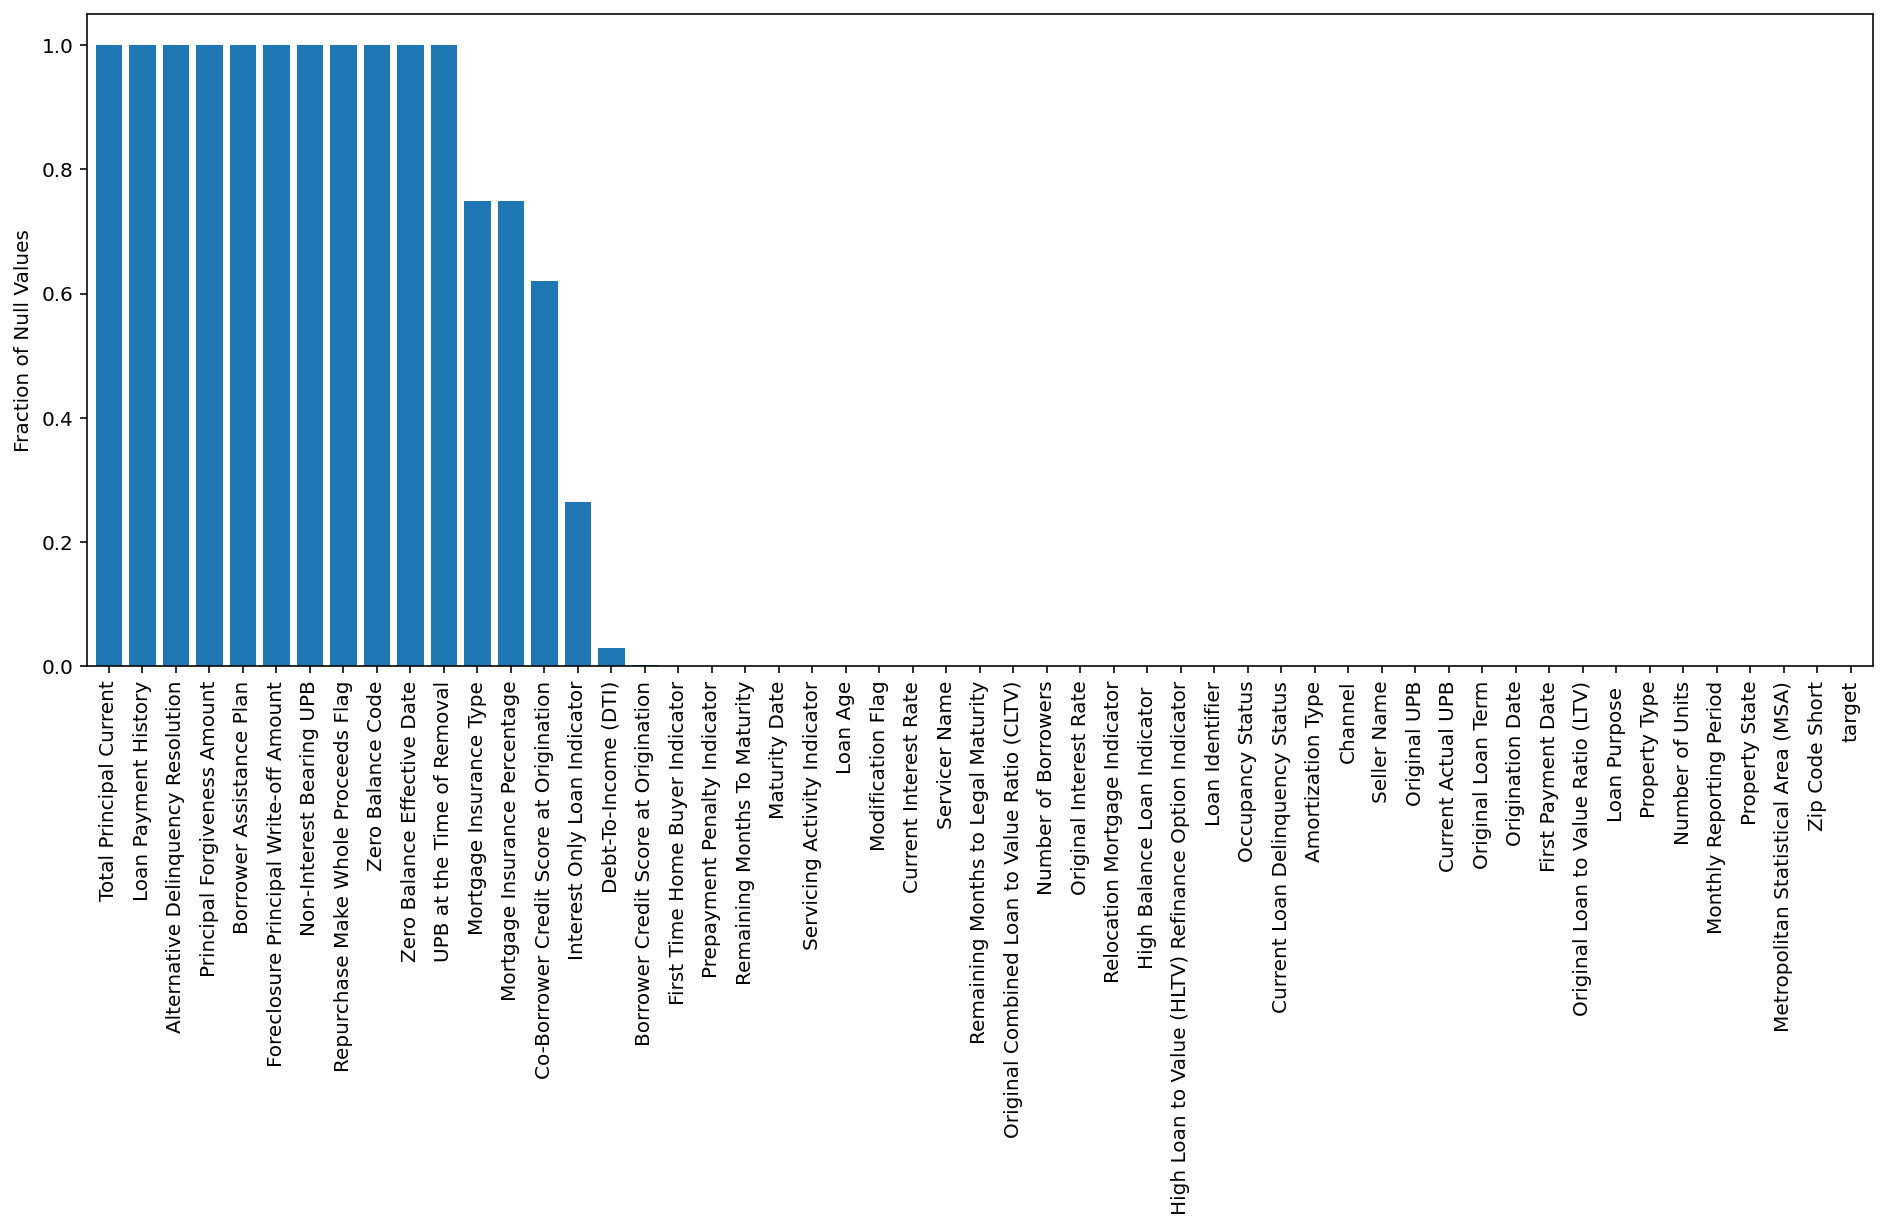

In [11]:
ax = (df.isnull().sum()/len(df)).sort_values(ascending=False).plot.bar(width=0.8, figsize=(16, 6))

ax.set_ylabel('Fraction of Null Values')

We can see that the first several fields nearly all of their values missing, so we'll grab those for removal as well.

In [12]:
mostly_missing_columns = [i for i in df.columns if df[i].isnull().sum()/len(df) > 0.99]

mostly_missing_columns

['Loan Payment History',
 'Zero Balance Code',
 'Zero Balance Effective Date',
 'UPB at the Time of Removal',
 'Total Principal Current',
 'Non-Interest Bearing UPB',
 'Principal Forgiveness Amount',
 'Foreclosure Principal Write-off Amount',
 'Borrower Assistance Plan',
 'Repurchase Make Whole Proceeds Flag',
 'Alternative Delinquency Resolution']

Lastly, several columns contain records where a vast majority take on the same value (e.g., Modification Flag), while othercolumns are not relevant to the analysis (e.g., Loan Identifier), or are near-duplicates of other columns (e.g., Current Interest Rate).

In [13]:
additional_columns = [
    'Loan Identifier',
    'Monthly Reporting Period',
    'Loan Age',
    'Maturity Date',
    'Current Loan Delinquency Status',
    'Current Actual UPB',
    'Remaining Months to Legal Maturity',
    'Original Combined Loan to Value Ratio (CLTV)',
    'Metropolitan Statistical Area (MSA)', 'Zip Code Short',
    'Servicing Activity Indicator',
    'Current Interest Rate',
    'Remaining Months To Maturity',
    'Modification Flag'
]

Let's combine all of the column names we'd like to remove and drop them from the dataset.

In [14]:
drop_columns = list(set(single_value_columns + mostly_missing_columns + additional_columns))

In [15]:
df = df.drop(drop_columns, axis=1)

### Exploration

Text(0.5, 0, 'Credit Score')

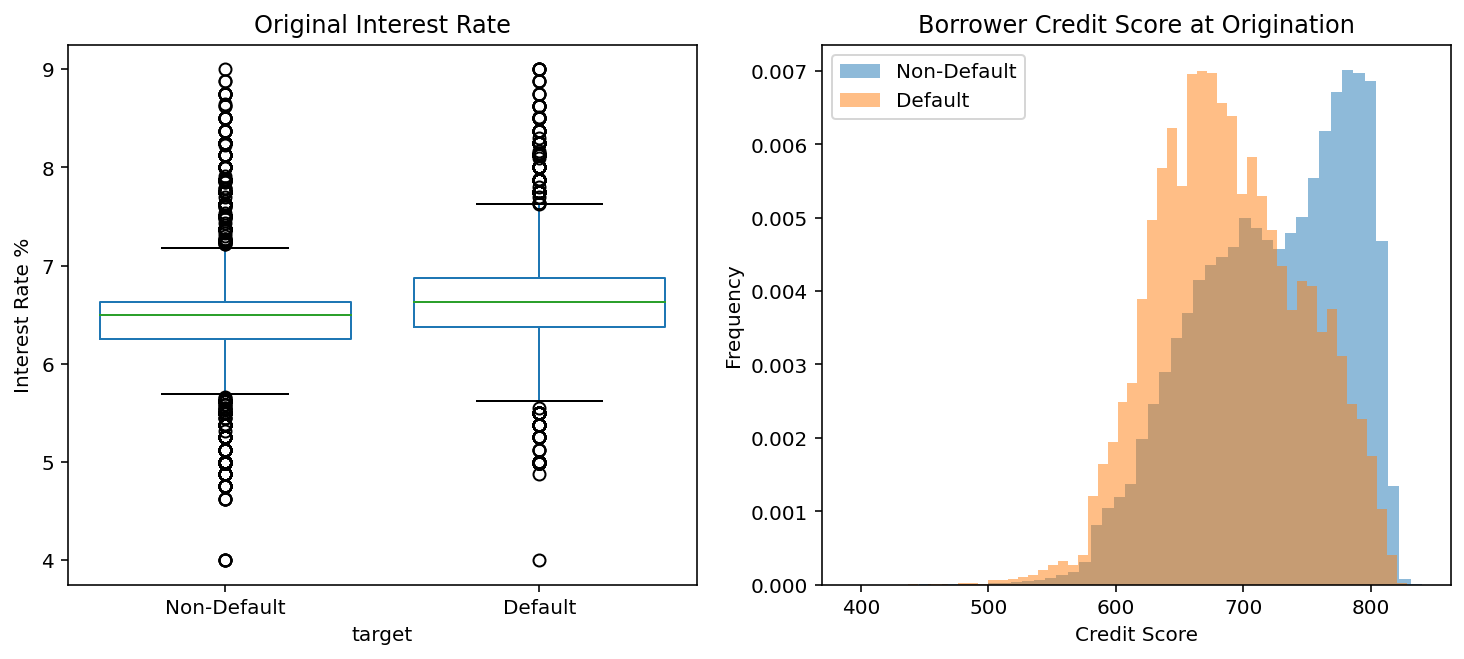

In [106]:
fig, axs = subplots(nrows=1, ncols=2, figsize=(12, 5))

df.boxplot(column='Original Interest Rate', by='target', widths=0.8, grid=False, ax=axs[0])

df.groupby('target')['Borrower Credit Score at Origination'].plot.hist(bins=50, alpha=0.5, density=True, ax=axs[1])

axs[0].get_figure().suptitle('')
axs[0].set_ylabel('Interest Rate %')
axs[0].set_xticklabels(['Non-Default', 'Default'])

axs[1].set_title('Borrower Credit Score at Origination')
axs[1].legend(['Non-Default', 'Default'])
axs[1].set_xlabel('Credit Score')

### Engineer some features

In [17]:
df['Origination Date'] = pd.to_datetime(df['Origination Date'].astype(str).str.zfill(6))

df['Origination Date Month'] = df['Origination Date'].apply(lambda x: x.month)

df['Origination Date Year'] = df['Origination Date'].apply(lambda x: x.year)

df.drop('Origination Date', axis=1, inplace=True)

In [18]:
df['First Payment Date'] = pd.to_datetime(df['First Payment Date'].astype(str).str.zfill(6))

df['First Payment Date Month'] = df['First Payment Date'].apply(lambda x: x.month)

df['First Payment Date Year'] = df['First Payment Date'].apply(lambda x: x.year)

df.drop('First Payment Date', axis=1, inplace=True)

In [19]:
df['Original Loan Term'] = pd.cut(df['Original Loan Term'], bins=[0, 120, 180, 240, 300, 360])

In [20]:
df['Original UPB'] = df['Original UPB'].clip(upper=400000)

### Split the data into training and test sets

In [21]:
df_tr, df_te = train_test_split(df, test_size=0.2, random_state=0)

In [22]:
df_tr.reset_index(drop=True, inplace=True)
df_te.reset_index(drop=True, inplace=True)

### Fill missing continuous values with the median value

In [23]:
df_tr['Original Interest Rate'] = df_tr['Original Interest Rate'].fillna(df_tr['Original Interest Rate'].median())
df_te['Original Interest Rate'] = df_te['Original Interest Rate'].fillna(df_tr['Original Interest Rate'].median())

df_tr['Debt-To-Income (DTI)'] = df_tr['Debt-To-Income (DTI)'].fillna(df_tr['Debt-To-Income (DTI)'].median())
df_te['Debt-To-Income (DTI)'] = df_te['Debt-To-Income (DTI)'].fillna(df_tr['Debt-To-Income (DTI)'].median())

df_tr['Borrower Credit Score at Origination'] = df_tr['Borrower Credit Score at Origination'].fillna(df_tr['Borrower Credit Score at Origination'].median())
df_te['Borrower Credit Score at Origination'] = df_te['Borrower Credit Score at Origination'].fillna(df_tr['Borrower Credit Score at Origination'].median())

df_tr['Co-Borrower Credit Score at Origination'] = df_tr['Co-Borrower Credit Score at Origination'].fillna(-999)
df_te['Co-Borrower Credit Score at Origination'] = df_te['Co-Borrower Credit Score at Origination'].fillna(-999)

df_tr['Mortgage Insurance Type'] = df_tr['Mortgage Insurance Type'].fillna(-999)
df_te['Mortgage Insurance Type'] = df_te['Mortgage Insurance Type'].fillna(-999)

### Fill categorical continuous values with the most frequent value

In [24]:
df_tr['Servicer Name'] = df_tr['Servicer Name'].fillna(df_tr['Servicer Name'].mode()[0])
df_te['Servicer Name'] = df_te['Servicer Name'].fillna(df_tr['Servicer Name'].mode()[0])

df_tr['Number of Borrowers'] = df_tr['Number of Borrowers'].fillna(df_tr['Number of Borrowers'].mode()[0])
df_te['Number of Borrowers'] = df_te['Number of Borrowers'].fillna(df_tr['Number of Borrowers'].mode()[0])

df_tr['First Time Home Buyer Indicator'] = df_tr['First Time Home Buyer Indicator'].fillna(df_tr['First Time Home Buyer Indicator'].mode()[0])
df_te['First Time Home Buyer Indicator'] = df_te['First Time Home Buyer Indicator'].fillna(df_tr['First Time Home Buyer Indicator'].mode()[0])

df_tr['Mortgage Insurance Percentage'] = df_tr['Mortgage Insurance Percentage'].fillna(-999)
df_te['Mortgage Insurance Percentage'] = df_te['Mortgage Insurance Percentage'].fillna(-999)

In [25]:
df_tr['Mortgage Insurance Percentage'] = pd.cut(df_tr['Mortgage Insurance Percentage'].fillna(-999),
                                                bins=[-999, 0, 12, 17, 25, 30, 35, 100], include_lowest=True)

df_te['Mortgage Insurance Percentage'] = pd.cut(df_te['Mortgage Insurance Percentage'].fillna(-999),
                                                bins=[-999, 0, 12, 17, 25, 30, 35, 100], include_lowest=True)

### Handle categorical and numerical columns

In [26]:
categorical_colunmns = [
    'Channel',
    'Seller Name',
    'Servicer Name',
    'Original Loan Term',
    'Number of Borrowers',
    'First Time Home Buyer Indicator',
    'Loan Purpose ',
    'Property Type',
    'Number of Units',
    'Occupancy Status',
    'Property State',
    'Mortgage Insurance Percentage',
    'Mortgage Insurance Type',
    'Relocation Mortgage Indicator',
    'Origination Date Month',
    'Origination Date Year',
    'First Payment Date Month',
    'First Payment Date Year'
]

In [27]:
numerical_columns = [i for i in df_tr.columns if i not in categorical_colunmns + ['target']]

In [28]:
tmp = pd.get_dummies(df_tr.append(df_te), columns=categorical_colunmns, drop_first=True)

df_tr = tmp[:len(df_tr)]
df_te = tmp[-len(df_te):]

In [29]:
sc = StandardScaler()

df_tr[numerical_columns] = sc.fit_transform(df_tr[numerical_columns])

df_te[numerical_columns] = sc.transform(df_te[numerical_columns])

In [30]:
print(f'Training set size: {df_tr.shape}')
print(f'Test set size: {df_te.shape}')

Training set size: (110446, 158)
Test set size: (27612, 158)


In [31]:
df_tr.head()

,Original Interest Rate,Original UPB,Original Loan to Value Ratio (LTV),Debt-To-Income (DTI),Borrower Credit Score at Origination,Co-Borrower Credit Score at Origination,target,Channel_C,Channel_R,"Seller Name_Bank Of America, N.A.","Seller Name_Bank of America, N.A.","Seller Name_Chase Home Finance, Llc","Seller Name_Citimortgage, Inc.","Seller Name_Fdic, Receiver, Indymac Federal Bank Fsb",Seller Name_First Tennessee Bank National Association,Seller Name_Flagstar Capital Markets Corporation,"Seller Name_Gmac Mortgage, Llc","Seller Name_Hsbc Bank Usa, National Association","Seller Name_Jpmorgan Chase Bank, National Association",Seller Name_Other,"Seller Name_Pnc Bank, N.A.",Seller Name_Suntrust Mortgage Inc.,"Seller Name_Wells Fargo Bank, N.A.","Servicer Name_Bank of America, N.A.","Servicer Name_Citimortgage, Inc.",Servicer Name_Ditech Financial Llc,"Servicer Name_Fannie Mae/Seterus, Inc. As Subservicer","Servicer Name_First Tennessee Bank, National Association","Servicer Name_Gmac Mortgage, Llc","Servicer Name_Green Tree Servicing, Llc","Servicer Name_Jp Morgan Chase Bank, Na","Servicer Name_Jpmorgan Chase Bank, Na","Servicer Name_Metlife Bank, Na","Servicer Name_Nationstar Mortgage, Llc",Servicer Name_Other,Servicer Name_Phh Mortgage Corporation,"Servicer Name_Pnc Bank, N.A.",Servicer Name_Regions Bank,Servicer Name_Suntrust Mortgage Inc.,Servicer Name_Usaa Federal Savings Bank,"Servicer Name_Wells Fargo Bank, N.A.","Original Loan Term_(120, 180]","Original Loan Term_(180, 240]","Original Loan Term_(240, 300]","Original Loan Term_(300, 360]",Number of Borrowers_2.0,Number of Borrowers_3.0,Number of Borrowers_4.0,Number of Borrowers_5.0,Number of Borrowers_6.0,Number of Borrowers_8.0,First Time Home Buyer Indicator_Y,Loan Purpose _P,Loan Purpose _R,Property Type_CP,Property Type_MH,Property Type_PU,Property Type_SF,Number of Units_2,Number of Units_3,Number of Units_4,Occupancy Status_P,Occupancy Status_S,Property State_AL,Property State_AR,Property State_AZ,Property State_CA,Property State_CO,Property State_CT,Property State_DC,Property State_DE,Property State_FL,Property State_GA,Property State_GU,Property State_HI,Property State_IA,Property State_ID,Property State_IL,Property State_IN,Property State_KS,Property State_KY,Property State_LA,Property State_MA,Property State_MD,Property State_ME,Property State_MI,Property State_MN,Property State_MO,Property State_MS,Property State_MT,Property State_NC,Property State_ND,Property State_NE,Property State_NH,Property State_NJ,Property State_NM,Property State_NV,Property State_NY,Property State_OH,Property State_OK,Property State_OR,Property State_PA,Property State_PR,Property State_RI,Property State_SC,Property State_SD,Property State_TN,Property State_TX,Property State_UT,Property State_VA,Property State_VI,Property State_VT,Property State_WA,Property State_WI,Property State_WV,Property State_WY,"Mortgage Insurance Percentage_(0.0, 12.0]","Mortgage Insurance Percentage_(12.0, 17.0]","Mortgage Insurance Percentage_(17.0, 25.0]","Mortgage Insurance Percentage_(25.0, 30.0]","Mortgage Insurance Percentage_(30.0, 35.0]","Mortgage Insurance Percentage_(35.0, 100.0]",Mortgage Insurance Type_1.0,Mortgage Insurance Type_2.0,Relocation Mortgage Indicator_Y,Origination Date Month_2,Origination Date Month_3,Origination Date Month_4,Origination Date Month_5,Origination Date Month_6,Origination Date Month_7,Origination Date Month_8,Origination Date Month_9,Origination Date Month_10,Origination Date Month_11,Origination Date Month_12,Origination Date Year_2002,Origination Date Year_2003,Origination Date Year_2005,Origination Date Year_2006,Origination Date Year_2007,First Payment Date Month_2,First Payment Date Month_3,First Payment Date Month_4,First Payment Date Month_5,First Payment Date Month_6,First Payment Date Month_7,First Payment Date Month_8,First Payment Date Month_9,First Payment Date Month_10,First Payment Date Month_11,First Payment Date Month_12,First Payment Date Year_2002,Firs

### Build the models

In [32]:
models = [KNeighborsClassifier(n_neighbors=5),
          LogisticRegression(solver='liblinear', penalty='l2'),
          LogisticRegression(solver='liblinear', penalty='l1'),
          RandomForestClassifier(n_estimators=100)]

for model in models:

    scores = cross_val_score(model, df_tr.drop('target', axis=1), df_tr['target'], scoring='roc_auc', cv=5)

    print(f'Cross-validation scores: {scores}, Mean score: {np.mean(scores)}')

Cross-validation scores: [0.70729399 0.71846691 0.71510185 0.71696573 0.7109679 ], Mean score: 0.7137592755066222
Cross-validation scores: [0.81186345 0.80941001 0.81164545 0.81122886 0.81138194], Mean score: 0.8111059426356734
Cross-validation scores: [0.81187844 0.80931008 0.81177156 0.81119532 0.81134481], Mean score: 0.8111000418833141
Cross-validation scores: [0.80478448 0.79858567 0.803425   0.80485619 0.79997482], Mean score: 0.8023252327741194


In [34]:
model = RandomForestClassifier(n_estimators=100)

model.fit(df_tr.drop('target', axis=1), df_tr['target'])

RandomForestClassifier()

In [38]:
predict = model.predict_proba(df_te.drop('target', axis=1))[:, 1]

fp, tp, threshold = roc_curve(df_te['target'], predict)

In [72]:
score = roc_auc_score(df_te['target'], predict)

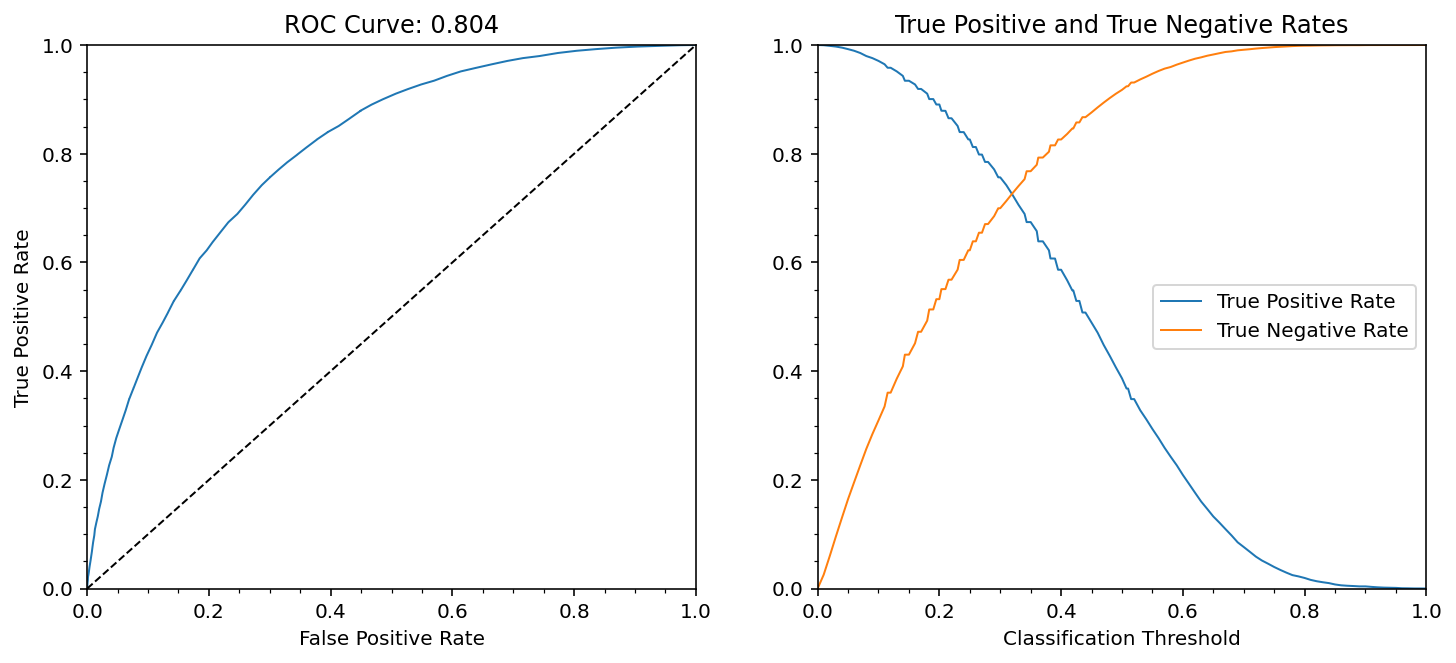

In [109]:
fig, axs = subplots(nrows=1, ncols=2, figsize=(12, 5))

axs[0].plot(fp, tp, lw=1)
axs[0].plot([0, 1], [0, 1], lw=1, ls='--', c='k')
axs[0].set_ylim(0, 1)
axs[0].set_xlim(0, 1)
axs[0].set_ylabel('True Positive Rate')
axs[0].set_xlabel('False Positive Rate')
axs[0].set_title(f'ROC Curve: {score.round(3)}')
axs[0].minorticks_on()

axs[1].plot(threshold, tp, lw=1)
axs[1].plot(threshold, 1 - fp, lw=1)
axs[1].set_ylim(0, 1)
axs[1].set_xlim(0, 1)
axs[1].set_xlabel('Classification Threshold')
axs[1].legend(['True Positive Rate', 'True Negative Rate'])
axs[1].set_title('True Positive and True Negative Rates')
axs[1].minorticks_on()

Text(0, 0.5, 'Relative Feature Importance')

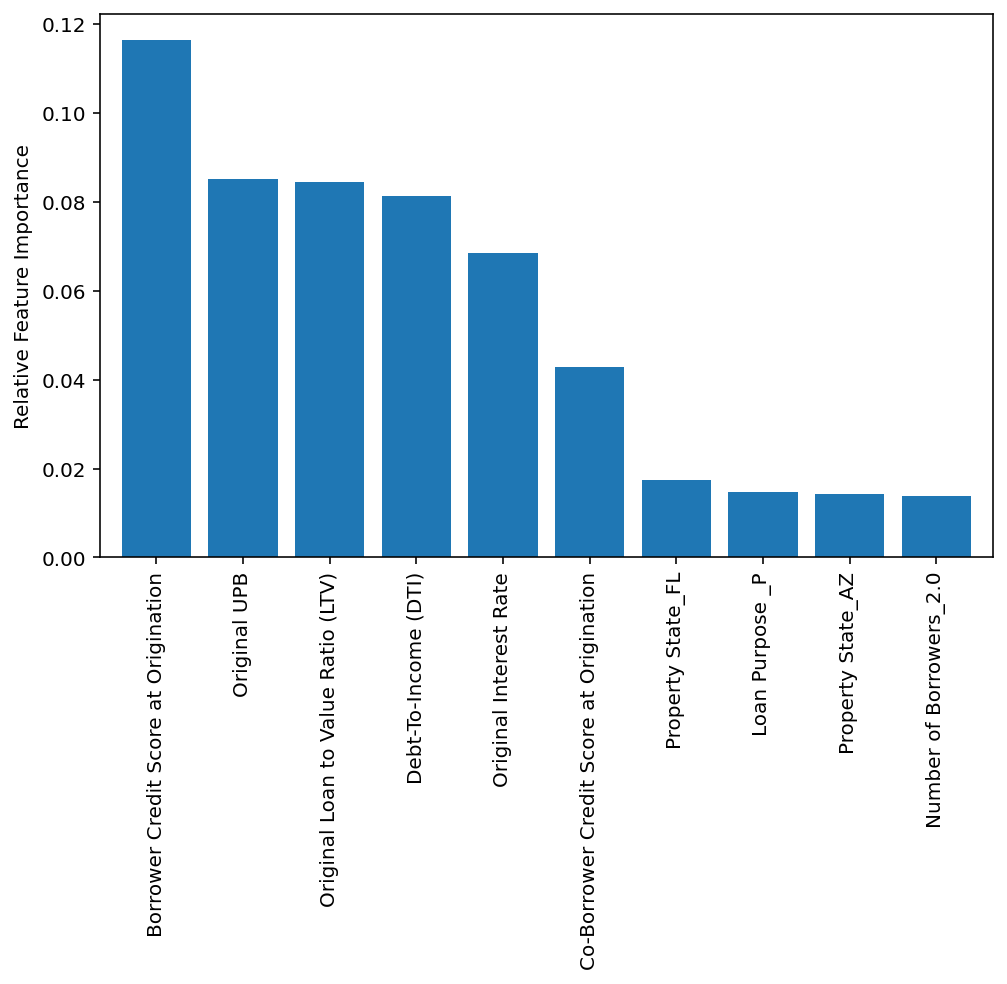

In [101]:
da = pd.DataFrame(columns=['Feature', 'Importance'])

da['Feature'] = df_te.drop('target', axis=1).columns

da['Importance'] = model.feature_importances_

ax = da.sort_values('Importance', ascending=False)[:10].plot.bar(x='Feature', width=0.8, legend=False, figsize=(8, 5))

ax.set_xlabel('')
ax.set_ylabel('Relative Feature Importance')

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>